In [1]:
from iminuit import Minuit
import matplotlib.pyplot as plt
from matplotlib import transforms
from matplotlib import rc
from IPython.display import Image
import numpy as np
from astropy.io import fits as pyfits
from astropy.io import fits
from scipy.ndimage import gaussian_filter
import scipy
from scipy.optimize import minimize, rosen, rosen_der
from scipy.special import factorial
import scipy.integrate as integrate
from scipy.integrate import quad
from itertools import starmap
from scipy import optimize
import corner
import time
from mpl_toolkits import mplot3d
import healpy as hp
from scipy import nan
import dark_matter_jfactors_test as dmj
import math
import random
import importlib
from pymultinest.solve import solve
import pymultinest
import warnings
warnings.filterwarnings("ignore")
import scipy as sp
import scipy.interpolate
import json
from os import walk
import re

In [2]:
filelist = ['Bremss_00320087_E_50-814008_MeV_healpix_128.fits', 'Bremss_SL_Z6_R20_T100000_C5_E_50-814008_MeV_healpix_128.fits', 'pi0_Model_A_E_50-814008_MeV_healpix_128.fits', 'pi0_Model_F_E_50-814008_MeV_healpix_128.fits', 'ICS_Model_A_E_50-814008_MeV_healpix_128.fits', 'ICS_Model_F_E_50-814008_MeV_healpix_128.fits']
evermore_shifted = np.asarray([
    [33, 21, 49],
    [154, 112, 82],
    [241, 149, 91],
    [142, 52, 38],
    [33, 21, 49],
])/256

point_sources = ['point_sources.fits']

#exposure_time = 4.1e6 #.13 years 47 days
exposure_time = 4.1e8 #13 years
#exposure_time = 4.1e9 #130 years
#exposure_time = 4.1e11 #13000 years
#exposure_time = 4.1e16 #13000 years
#exposure_time = 3.154e10


In [3]:
def readfile(filename):
    """
    A simple function to read the maps of a given number n and given filename.
    """
    file_to_read = fits.open(filename)
    return file_to_read

def reshape_file(hdu, n, inner20 = True):
    """
    Reshapes the data to be in the size we want
    """
    
    if inner20:
        numpix = np.linspace(0, hdu[0].header['NPIX']-1, num = hdu[0].header['NPIX'])
        NSIDE = int(hdu[0].header['NSIDE'])
        degrees = hp.pix2ang(NSIDE, np.array(numpix,dtype=np.int), lonlat = True)
        vec = hp.ang2vec(np.pi/2, 0)
        ipix_disc20 = hp.query_disc(nside=NSIDE, vec=vec, radius=np.radians(20), inclusive = False)
        
        data4 = hdu[n].data
        test20 = np.copy(data4)[ipix_disc20]
        
        #might need this for plotting, not sure
        #data4 = hdu[n].data
        #test20 = np.copy(data4)
        #test20[inner_20] = np.nan
        #testbin = np.reshape(test20, (128*3, 1536//3))

    else:
        """
        testbin = np.reshape(hdu[n].data, (128*3, 1536//3))
        
        """
        numpix = np.linspace(0, hdu[0].header['NPIX']-1, num = hdu[0].header['NPIX'])
        NSIDE = int(hdu[0].header['NSIDE'])
        degrees = hp.pix2ang(NSIDE, np.array(numpix,dtype=np.int), lonlat = True)
        
        inner_20_pos = (np.sqrt((degrees[0])**2+degrees[1]**2)> 20)
        inner_20_neg = (np.sqrt((degrees[0]-360)**2+degrees[1]**2)> 20)
        inner_20 = np.logical_and(inner_20_pos, inner_20_neg)
        
        data4 = hdu[n].data
        test20 = np.copy(data4)
        #test20[inner_20] = np.nan
        #print(sum(~np.isnan(test20)))
        #testbin = np.reshape(test20, (128*3, 1536//3))
        
    return test20

def get_energy_index(E_desired, hdu):
    energy_hdu = np.concatenate(hdu[38].data, axis = 0)
    idx = find_nearest(energy_hdu, E_desired)
    return idx
    
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
    

In [4]:


def log_interp1d(xx, yy, kind='linear'):
    logx = np.log10(xx)
    logy = np.log10(yy)
    lin_interp = sp.interpolate.interp1d(logx, logy, kind=kind, fill_value="extrapolate")
    log_interp = lambda zz: np.power(10.0, lin_interp(np.log10(zz)))
    return log_interp

def get_all_egb_data(energies, deltae):
    energy_range = np.array([(.1, .14), (.14, .2), (.2, .28), (.28, .4), (.4, .57), (.57, .8), (.8, 1.1), (1.1, 1.6), (1.6, 2.3), (2.3, 3.2), (3.2, 4.5), (4.5, 6.4), (6.4, 9.1), (9.1, 13), (13, 18), (18, 26), (26, 36), (36, 51), (51, 72), (72, 100), (100, 140), (140, 200), (200, 290), (290, 410), (410, 580), (580, 820)])*1e3 #GeV to MeV
    egb_intensity = np.array([3.7e-6, 2.3e-6, 1.5e-6, 9.7e-7, 6.7e-7, 4.9e-7, 3e-7, 1.8e-7, 1.1e-7, 6.9e-8, 4.2e-8, 2.6e-8, 1.7e-8, 1.2e-8, 6.8e-9, 4.4e-9, 2.7e-9, 1.8e-9, 1.1e-9, 6.2e-10, 3.1e-10, 1.9e-10, 8.9e-11, 6.3e-11, 2.1e-11, 9.7e-12])
    middle_bin = []
    bin_width = []
    for i in range(0, len(energy_range)):
        low_e = np.log10(energy_range[i][0])
        high_e = np.log10(energy_range[i][1])
        difference = np.abs((low_e+high_e)/2)
        middle_bin.append(10**(difference))
        bin_width.append(np.abs(energy_range[i][1]-(10**(difference)))) 
    return middle_bin, bin_width, egb_intensity

def get_all_egb(energies, deltae):
    energy_range = np.array([(.1, .14), (.14, .2), (.2, .28), (.28, .4), (.4, .57), (.57, .8), (.8, 1.1), (1.1, 1.6), (1.6, 2.3), (2.3, 3.2), (3.2, 4.5), (4.5, 6.4), (6.4, 9.1), (9.1, 13), (13, 18), (18, 26), (26, 36), (36, 51), (51, 72), (72, 100), (100, 140), (140, 200), (200, 290), (290, 410), (410, 580), (580, 820)])*1e3 #GeV to MeV
    egb_intensity = np.array([3.7e-6, 2.3e-6, 1.5e-6, 9.7e-7, 6.7e-7, 4.9e-7, 3e-7, 1.8e-7, 1.1e-7, 6.9e-8, 4.2e-8, 2.6e-8, 1.7e-8, 1.2e-8, 6.8e-9, 4.4e-9, 2.7e-9, 1.8e-9, 1.1e-9, 6.2e-10, 3.1e-10, 1.9e-10, 8.9e-11, 6.3e-11, 2.1e-11, 9.7e-12])
    middle_bin = []
    bin_width = []
    for i in range(0, len(energy_range)):
        low_e = np.log10(energy_range[i][0])
        high_e = np.log10(energy_range[i][1])
        difference = np.abs((low_e+high_e)/2)
        middle_bin.append(10**(difference))
        bin_width.append(np.abs(energy_range[i][1]-(10**(difference)))) 
        

    log_interp = log_interp1d(middle_bin, egb_intensity/bin_width, kind='linear')
    
    '''
    print(egb_intensity[2]/bin_width[2]*deltae[6])
    print(energies[6])
    x_trapz = np.logspace(np.log10(np.nanmin(energies)), np.log10(np.nanmax(energies)), num = 100)
    plt.scatter(middle_bin, egb_intensity/bin_width)
    plt.plot(x_trapz, log_interp(x_trapz), color = 'red')
    plt.scatter(energies[6], log_interp(energies[6]), color = 'green')
    plt.yscale('log')
    plt.xscale('log')
    '''
    
    counts = []
    #only want energies from 3 onward (about lowest at 80 MeV)
    for x in range(3, len(energies)):
        highest_val = energies[x]+deltae[x]
        lowest_val = energies[x]-deltae[x]
        x_trapz = np.logspace(np.log10(lowest_val), np.log10(highest_val), num = 400)
        #counts.append(log_interp(energies[x])*deltae[x])
        total_counts = np.trapz(log_interp(x_trapz), x = x_trapz)
        
        #print('total counts: {}'.format(total_counts))
        '''
        plt.scatter(middle_bin, egb_intensity/bin_width)
        plt.plot(x_trapz, log_interp(x_trapz), color = 'red')
        plt.scatter(energies[x], total_counts)
        
        plt.yscale('log')
        plt.xscale('log')
        asdfads
        '''
        counts.append(total_counts)  
    return counts #returns counts per cm^2 per sec per str


In [5]:
def subtract(n):
    ##Template for 1 GeV and 10 GeV
    icsa = readfile(filelist[n])
    
    idx1 = get_energy_index(1*1e3, icsa)
    idx10 = get_energy_index(10*1e3, icsa)
    
    array1 = reshape_file(icsa, idx1, inner20 = False)
    array10 = reshape_file(icsa, idx10, inner20 = False)
    
    ##Sum up idx1 and idx 10, make them equal in sum
    sum1 = np.nansum(array1)
    sum10 = np.nansum(array10)
    array10_adjusted = (array10*sum1/sum10)
    subtract110 = np.abs(array1-array10_adjusted)/array1
    fig, ax = plt.subplots(figsize=(10, 10))
    image = ax.imshow(subtract110)
    fig.colorbar(image, ax=ax, anchor=(0, 0.3), shrink=0.7)
    plt.title(str(filelist[n]))
    
    return

In [6]:


#n = 4 for ICSA, n = 2 for pi0
def psf_smoothing(n, energyidx, inner20psf = False, pointsource = False):
    inner20psf = False
    if pointsource:
        icsa = readfile(point_sources[0])
        data50 = icsa[energyidx-3].data
    else:
        icsa = readfile(filelist[n])
        data50 = reshape_file(icsa, energyidx, inner20 = inner20psf)
    hdu = readfile(filelist[0])


    
    
    #data50 = reshape_file(icsa, energyidx, inner20 = inner20psf) #get the data at 50 MeV
    
    #get_where_within_20deg
    numpix = np.linspace(0, hdu[0].header['NPIX']-1, num = hdu[0].header['NPIX'])
    NSIDE = int(hdu[0].header['NSIDE'])
    vec = hp.ang2vec(np.pi/2, 0)
    ipix_disc = hp.query_disc(nside=NSIDE, vec=vec, radius=np.radians(20), inclusive = False)
    
    init_sum = np.sum(data50[ipix_disc])
    #print(init_sum)
    
    data50_convolved = hp.sphtfunc.smoothing(data50.flatten(), sigma=np.pi/180/1.508)
    
    hp.mollview(np.log10(data50_convolved))

    fin_sum = np.sum(data50_convolved[ipix_disc])
    #print(fin_sum)
    

    #data50_convolved = gaussian_filter(data50, sigma=0)
    
    #only get data within 20 degrees
    #hp.mollview(np.log10(data50_convolved), coord = 'G')
    
    
    testbin = data50_convolved[ipix_disc]
    #print(len(testbin))
    data50_convolved[ipix_disc] = np.nan
    hp.mollview(data50_convolved)


    return np.array(testbin)*init_sum/fin_sum

def psf_smoothing_DM(energyidx, crosssec = 2.2e-26, anal_data = False, mass_dm = 100):
    energybin = np.concatenate(readfile(filelist[0])[38].data, axis = 0)[energyidx]
    bins_in_lin = np.log10(energybin)
    deltae = get_deltaE(energyidx)
    
    highe = (energybin+deltae)/1e3
    lowe = (energybin-deltae)/1e3
    
    hdu = readfile(filelist[0])
    numpix = np.linspace(0, hdu[0].header['NPIX']-1, num = hdu[0].header['NPIX'])
    NSIDE = int(hdu[0].header['NSIDE'])
    
    degrees = hp.pix2ang(NSIDE, np.array(numpix,dtype=np.int), lonlat = True)
    
    
    #need to make sure the initsum is *only within the inner 20 degrees, same for finsum
    data50 = dmj.get_dNdE(highe, lowe, sigmav = crosssec, analyze_data = anal_data, massx = mass_dm)[1] #photons per cm^2 per sec per str per MeV
    
    #get_where_within_20deg
    numpix = np.linspace(0, hdu[0].header['NPIX']-1, num = hdu[0].header['NPIX'])
    NSIDE = int(hdu[0].header['NSIDE'])
    vec = hp.ang2vec(np.pi/2, 0)
    ipix_disc = hp.query_disc(nside=NSIDE, vec=vec, radius=np.radians(20), inclusive = False)
    
    init_sum = np.sum(data50[ipix_disc])
    
    hp.mollview(np.log10(data50), coord = 'G')
    
    data50_convolved = hp.sphtfunc.smoothing(data50, sigma=np.pi/180/1.508)
    fin_sum = np.sum(data50_convolved[ipix_disc])
    data50_convolved[ipix_disc] = np.nan
    hp.mollview(data50_convolved)
    
    #photons per cm^2 per sec per str per MeV
    
    return np.array(data50_convolved[ipix_disc])*init_sum/fin_sum

def poisson_dist(n, energyidx, cross_section =2.2e-26, dm = False, analyze_data = False, dm_mass = 100, egb = False, points = False, counts = 0):   
    '''
    Performs a PSF smoothing of the array, before converting it into photons per pixel
    
    '''
    deltaE = get_deltaE(energyidx)
    if dm:
        convolved_data = psf_smoothing_DM(energyidx, cross_section, anal_data = analyze_data, mass_dm = dm_mass)/deltaE
    elif egb:
        convolved_data_init = np.empty(5938) #needs to be the length of the good vals
        convolved_data_init.fill(1)
        convolved_data = convolved_data_init*counts #in units of photons per cm^2 per mev per str per sec
    elif points:
        convolved_data = psf_smoothing(n, energyidx, pointsource = True)
    else:
        convolved_data = psf_smoothing(n, energyidx, cross_section) #data in units of photons cm^-2 MeV^-1 str^-1
    deltaomega = 4*np.pi/196608 #divide by num of pixels
    n_gamma = np.array(convolved_data)*deltaE*exposure_time*8500*deltaomega*.2 #13 years*.85meters^2, units of photons per pixel
    
    return n_gamma

def get_deltaE(n):
    energybins = np.concatenate(readfile(filelist[0])[38].data, axis = 0)
    bins_in_lin = np.log10(energybins)[n]
    spacing = 0.05691431
    
    high_bin = 10**(bins_in_lin + spacing)
    low_bin = 10**(bins_in_lin - spacing)
    
    deltaE = np.abs(high_bin - low_bin)
    #print('delta E: {}'.format(deltaE))
    
    return deltaE

def get_image(data):
    fig, ax = plt.subplots(figsize=(10, 10))
    image = ax.imshow(data)
    fig.colorbar(image, ax=ax, anchor=(0, 0.3), shrink=0.7)
    return

def simulated_data(energyidx, templates):
    
    '''
    Use PSF smoothed data to create a random poisson draw to obtain simulated data
    '''
    
    
    n_gammatot = 0
    for i in range(0, len(templates)):
        n_gammatot += templates[i]
    len_of_rand = len(n_gammatot)
    simdata = np.zeros(len_of_rand)
    randdata = np.random.rand(len_of_rand)
    
    #print(n_gammatot)
    
    for i in range(0, len_of_rand):
        #print(n_gammatot[i])
        if n_gammatot[i]<.01:
            if n_gammatot[i] < randdata[i]:
                simdata[i] = 0
            else:
                simdata[i] = 1
        else:
            simdata[i] = np.random.poisson(lam = n_gammatot[i])
    #print('simdata just 20: ', np.nansum(simdata))
    
    return simdata

def minimize_likelihood(energyidx, cross_sec = 2.2e-26, massdm = 100):
    pi = poisson_dist(2, energyidx)
    ics = poisson_dist(4, energyidx)   
    brem = poisson_dist(0, energyidx)

    darkm = poisson_dist(np.nan, energyidx, cross_section = cross_sec, dm = True, dm_mass = massdm)

    k = simulated_data(energyidx, [pi, ics, brem])#remove DM for accurate
    #print(np.nanmean(lamb))
    #asdfasd
    
    #Need to minimize for lamb < 50 and lamb > 50
    
    bnds = ((0, np.inf), (0, np.inf), (0, np.inf), (1e-30, np.inf))
    result = minimize(likelihood, (1, 1, 1, 1), args = (k, pi, ics, brem, darkm), bounds = bnds)
    min_likelihood = result.x
    chi2 = result.fun
    #print(result)

    return min_likelihood


def likelihood(constants, k, pi, ics, brem, dm):
    """
    Gets the Total Likelihoods from the Gaussian Regime and the Poisson Regime
    Once each has been calculated, multiplies values together for final likelihood
    """
    
    likelihood_poiss = likelihood_poisson(constants, k, pi, ics, brem, dm)
    #print('likelihood: {}'.format(likelihood_poiss)) 
    return likelihood_poiss

def merge(list1, list2):
      
    merged_list = tuple(zip(list1, list2)) 
    return merged_list

def likelihood_gaussian(constants, lamb, pi, ics):
    sigma = np.sqrt(constants[0]*pi+constants[1]*ics)
    mu = lamb
    rng = 0.5
    
    #flatten arrays
    sigma_flat = sigma.flatten()
    mu_flat = mu.flatten()
    length_flattened = len(mu_flat)
    #get arrays in sigma, mu tuple format
    ms_tuples = list(merge(mu_flat, sigma_flat))
    ms = np.array(ms_tuples, dtype = 'f,f')
    lower_bound_arr = mu_flat - rng
    upper_bound_arr = mu_flat + rng
    
    args = np.concatenate((np.full((length_flattened, 1), prob_func), lower_bound_arr.reshape((length_flattened, 1)), upper_bound_arr.reshape((length_flattened, 1)), ms.reshape((length_flattened, 1))), axis = 1)
    
    #log likelihood
    prob = list(starmap(lambda a, b, c, d: quad(a, b, c, d)[0], args))

    #reshape for testing
    l = np.sum(np.log(prob))
    likely = -2*l
    
    return likely
    
def prob_func(x, mu, sigma):
    probdens = 1/(sigma*np.sqrt(2*np.pi))*np.exp(-1/2*((x-sigma**2)/sigma)**2)
    return probdens

#def likelihood_poisson(a0):
def likelihood_poisson(a0, a1, a2, a3, a4):
#def likelihood_poisson(constants, ktest, pitest, icstest, bremtest, dmtest):
    lamb = a0*pitest+a1*icstest+a2*bremtest+a3*darkmtest+a4*egbtest
    #lamb = a0*egbtest
    
    #print(a0, a1, a2, a3)
    #print(lamb)

    #lamb = constants[0]*pitest+constants[1]*icstest+constants[2]*bremtest+constants[3]*dmtest
    
    fprob = -scipy.special.gammaln(ktest+1)+ktest*np.log(lamb)-lamb #log likelihood of poisson
    #print(fprob)
    return -2*np.nansum(fprob)

def get_curves(n, energyidx, inner20psf = True):
    icsa = readfile(filelist[n])
    data50 = reshape_file(icsa, energyidx, inner20 = inner20psf) #get the data at energyidx MeV
    delt = get_deltaE(energyidx)
    return np.asarray(data50)*exposure_time*8500*.2*delt #13 years * .85 m^2 * .2, return in photons /str
    
def get_normalizations_spectrum(deltaE, cross_sec = 2.2e-26, dm_mass = 100):
    
    range_templates = [2, 4, 0] #pi, ics, brem
    e = readfile(filelist[0])[38].data
    energies = np.array(list(e)).T[0]
    templates = []
    temp = []
    deltaomega = 4*np.pi/196608 #i think this should maybe still be total bins in whole image pre-20?
    
    

    for n in range_templates:
        temp = []
        for index in range(3, len(energies)):
            temp.append(np.nansum(get_curves(n, index))) #units of photons per str
        templates.append(np.asarray(temp)*deltaomega) #gets counts per bin

    #dark matter template
    
    dm_temp = []
    dm_templates_tot = []
    for index in range(3, len(energies)):
        energybin = np.concatenate(readfile(filelist[0])[38].data, axis = 0)[index]
        bins_in_lin = np.log10(energybin)
        deltae = get_deltaE(index)
    
        highe = (energybin+deltae)/1e3
        lowe = (energybin-deltae)/1e3
        data50 = dmj.get_dNdE(highe, lowe, sigmav = cross_sec, massx = dm_mass, for_normals = True)[1] #units of photons cm^-2 str^-1 per sec not per MeV?
        #need to cut this to be inner 20 degrees
        
        
        #dm_temp.append(np.nansum(data50))
        dm_temp.append(np.nansum(data50)*exposure_time*8500) #13 years * .85 m^2 * .2, return in photons/str
    dm_templates_tot.append(np.asarray(dm_temp)*deltaomega) #photons per pixel?
    #print(np.nansum(dm_templates_tot[0]))
    
    #EGB template
    egb_templates = np.array(get_all_egb(energies, deltaE)) #units of counts per cm^2 per sec per str
    egb_temp_fin = egb_templates*8500*exposure_time*deltaomega #counts per bin
    
    #Point Source Template
    point_source_arr = []
    for index in range(3, len(energies)):
        smaller_index = int(index - 3)
        point_source_arr.append(np.nansum(get_curves_pointsource(index, smaller_index, inner20psf = True))*deltaomega) #photons per pixel
        
    print('yay!')
        
            
    return range_templates, energies, [np.array(templates[0])*.2, np.array(templates[1])*.2, np.array(templates[2])*.2, np.array(dm_templates_tot)*.2, np.array(egb_temp_fin)*.2, np.array(point_source_arr)*.2] #counts per pixel
    #return range_templates, np.asarray(dm_temp)*deltaomega
    
def get_curves_pointsource(energyidx, smallindex, inner20psf = True):
    pointsourcedata = readfile(point_sources[0])[smallindex].data
    
    hdu = readfile(filelist[0])
    numpix = np.linspace(0, hdu[0].header['NPIX']-1, num = hdu[0].header['NPIX'])
    NSIDE = int(hdu[0].header['NSIDE'])
    
    degrees = hp.pix2ang(NSIDE, np.array(numpix,dtype=np.int), lonlat = True)
    vec = hp.ang2vec(np.pi/2, 0)
    ipix_disc20 = hp.query_disc(nside=NSIDE, vec=vec, radius=np.radians(20), inclusive = False)
        
    test20 = np.copy(pointsourcedata)[ipix_disc20]
    
    delt = get_deltaE(energyidx)
    return np.asarray(test20)*exposure_time*8500*.2*delt #13 years * .85 m^2 * .2, return in photons /str
    
    
def get_normalized(energyidx, normals, template_val, energies):
    '''
    Normalizes the ROI based on the shape the spectrums should have
    
    
    Do not need to use this, as long as you stay consistent across all Fermi data
    for the exposure time and collecting area
    
    '''
    
    poisson_pi = poisson_dist(template_val, int(energyidx)) #units of photons per pixel
    init_sum_pi = np.nansum(poisson_pi)
    #print(np.nansum(init_sum_pi))
    if template_val == 2:
        normval = 0
    if template_val == 4:
        normval = 1
    if template_val == 0:
        normval = 2
    print('normval for pi at 0: {}'.format(normals[normval][energyidx])) 
    print('delta E at 0: {}'.format(get_deltaE(energyidx)))
    normal_pi = normals[normval][energyidx]*get_deltaE(energyidx)
    pitest = poisson_pi*normal_pi/init_sum_pi
    print('normalization: {}'.format(np.nansum(pitest)))
    #print(np.nansum(pitest))
    
    #print('----------------------')
    
    return pitest
    

In [7]:


def get_darksusy_counts():
    x = np.loadtxt('yield_DS_keith100.dat', dtype=str).T
    energies = x[1].astype(np.float)*1e3
    yieldperann = x[2].astype(np.float)/1e3 #convert from per GeV to per MeV
    energybins = np.concatenate(readfile(filelist[0])[38].data, axis = 0)
    
    counts = []
    delta = []
    for n in range(0, 38):
        
        bins_in_lin = energybins[n]
        deltae = get_deltaE(n)
    
        highe = (bins_in_lin+deltae)
        lowe = (bins_in_lin-deltae)
        
        good_energies = np.where((energies <=highe) & (energies >= lowe))
        
        final_integral = np.trapz(yieldperann[good_energies], x = energies[good_energies])

        counts.append(final_integral)
        delta.append(deltae)
    return np.array(counts), np.array(delta)



def log_interp1d(xx, yy, kind='linear'):
    logx = np.log10(xx)
    logy = np.log10(yy)
    lin_interp = sp.interpolate.interp1d(logx, logy, kind=kind, fill_value="extrapolate")
    log_interp = lambda zz: np.power(10.0, lin_interp(np.log10(zz)))
    return log_interp

def get_all_egb_data(energies, deltae):
    energy_range = np.array([(.1, .14), (.14, .2), (.2, .28), (.28, .4), (.4, .57), (.57, .8), (.8, 1.1), (1.1, 1.6), (1.6, 2.3), (2.3, 3.2), (3.2, 4.5), (4.5, 6.4), (6.4, 9.1), (9.1, 13), (13, 18), (18, 26), (26, 36), (36, 51), (51, 72), (72, 100), (100, 140), (140, 200), (200, 290), (290, 410), (410, 580), (580, 820)])*1e3 #GeV to MeV
    egb_intensity = np.array([3.7e-6, 2.3e-6, 1.5e-6, 9.7e-7, 6.7e-7, 4.9e-7, 3e-7, 1.8e-7, 1.1e-7, 6.9e-8, 4.2e-8, 2.6e-8, 1.7e-8, 1.2e-8, 6.8e-9, 4.4e-9, 2.7e-9, 1.8e-9, 1.1e-9, 6.2e-10, 3.1e-10, 1.9e-10, 8.9e-11, 6.3e-11, 2.1e-11, 9.7e-12])
    middle_bin = []
    bin_width = []
    for i in range(0, len(energy_range)):
        low_e = np.log10(energy_range[i][0])
        high_e = np.log10(energy_range[i][1])
        difference = np.abs((low_e+high_e)/2)
        middle_bin.append(10**(difference))
        bin_width.append(np.abs(energy_range[i][1]-(10**(difference)))) 
    return middle_bin, bin_width, egb_intensity

def get_all_egb(energies, deltae):
    energy_range = np.array([(.1, .14), (.14, .2), (.2, .28), (.28, .4), (.4, .57), (.57, .8), (.8, 1.1), (1.1, 1.6), (1.6, 2.3), (2.3, 3.2), (3.2, 4.5), (4.5, 6.4), (6.4, 9.1), (9.1, 13), (13, 18), (18, 26), (26, 36), (36, 51), (51, 72), (72, 100), (100, 140), (140, 200), (200, 290), (290, 410), (410, 580), (580, 820)])*1e3 #GeV to MeV
    egb_intensity = np.array([3.7e-6, 2.3e-6, 1.5e-6, 9.7e-7, 6.7e-7, 4.9e-7, 3e-7, 1.8e-7, 1.1e-7, 6.9e-8, 4.2e-8, 2.6e-8, 1.7e-8, 1.2e-8, 6.8e-9, 4.4e-9, 2.7e-9, 1.8e-9, 1.1e-9, 6.2e-10, 3.1e-10, 1.9e-10, 8.9e-11, 6.3e-11, 2.1e-11, 9.7e-12])
    middle_bin = []
    bin_width = []
    for i in range(0, len(energy_range)):
        low_e = np.log10(energy_range[i][0])
        high_e = np.log10(energy_range[i][1])
        difference = np.abs((low_e+high_e)/2)
        middle_bin.append(10**(difference))
        bin_width.append(np.abs(energy_range[i][1]-(10**(difference)))) 
        

    log_interp = log_interp1d(middle_bin, egb_intensity/bin_width, kind='linear')
    
    '''
    print(egb_intensity[2]/bin_width[2]*deltae[6])
    print(energies[6])
    x_trapz = np.logspace(np.log10(np.nanmin(energies)), np.log10(np.nanmax(energies)), num = 100)
    plt.scatter(middle_bin, egb_intensity/bin_width)
    plt.plot(x_trapz, log_interp(x_trapz), color = 'red')
    plt.scatter(energies[6], log_interp(energies[6]), color = 'green')
    plt.yscale('log')
    plt.xscale('log')
    '''
    
    counts = []
    #only want energies from 3 onward (about lowest at 80 MeV)
    for x in range(3, len(energies)):
        highest_val = energies[x]+deltae[x]
        lowest_val = energies[x]-deltae[x]
        x_trapz = np.logspace(np.log10(lowest_val), np.log10(highest_val), num = 400)
        #counts.append(log_interp(energies[x])*deltae[x])
        total_counts = np.trapz(log_interp(x_trapz), x = x_trapz)
        
        #print('total counts: {}'.format(total_counts))
        '''
        plt.scatter(middle_bin, egb_intensity/bin_width)
        plt.plot(x_trapz, log_interp(x_trapz), color = 'red')
        plt.scatter(energies[x], total_counts)
        
        plt.yscale('log')
        plt.xscale('log')
        asdfads
        '''
        counts.append(total_counts)  
    return counts #returns counts per cm^2 per sec per str




In [ ]:
importlib.reload(dmj)
#gets darksusy counts for a specific dark matter mass
counts, deltae = get_darksusy_counts()
#be sure to change the dm mass
temps, energies, normals = get_normalizations_spectrum(deltae, cross_sec = 2.2e-26)


sigmav: 2.2e-26
sigmav: 2.2e-26


In [11]:
#main chunk of code now
#testing pymultinest



#code that returns the log-likelihood at a specific point. cube is first parameter, everything else are random parameters
#that are not part of the fitting cube
def likelihood_poisson_multinest(cube, pitest, icstest, bremtest, darkmtest, egbtest, pointstest, ktest):
    #a0 = 10**cube[0]
    a0 = 10**cube[0]
    a1 = 10**cube[1]
    a2 = 10**cube[2]
    a3 = 10**cube[3]
    a4 = 10**cube[4]
    a5 = 10**cube[5]
    lamb = a0*pitest+a1*icstest+a2*bremtest+a3*darkmtest+a4*egbtest+a5*pointstest
    fprob = -scipy.special.gammaln(ktest+1)+ktest*np.log(lamb)-lamb #log likelihood of poisson
    return 2*np.nansum(fprob) #perhaps add negative back, perhaps add 2 back?

##This is the prior function, it is flat in linear space, from a minimum value specified by the first number, 
#to a maximum number specified by the first number + the second number. 
#The variables were called a/b/c/phi0/phi1/norm in this code.
#You need to define a prior for every parameter you send

cube_limits = [(-1, 2), (-1, 2), (-1, 2), (-2, 8), (-1, 2), (-1, 2)]

def prior(cube, ndim, nparams):
    #cube[0] = (cube[0]*np.abs(np.log10(1.1)-np.log10(.9)) - np.log10(.9)) #from 1e-4 to 1e6 apparently
    cube[0] = (cube[0]*cube_limits[0][1] + cube_limits[0][0])
    cube[1] = (cube[1]*cube_limits[1][1] + cube_limits[1][0])
    cube[2] = (cube[2]*cube_limits[2][1] + cube_limits[2][0])
    cube[3] = (cube[3]*cube_limits[3][1] + cube_limits[3][0])
    cube[4] = (cube[4]*cube_limits[4][1] + cube_limits[4][0])
    cube[5] = (cube[5]*cube_limits[5][1] + cube_limits[5][0])
    return cube

##This is the loglikelihood function for multinest – it sends the cube,
#and then a bunch of different arrays that were used in fitting, but were constant, to the pymultinest code
def loglikelihood_formulti(cube, ndim, nparms):
    return likelihood_poisson_multinest(cube, pitest, icstest, bremtest, darkmtest, egbtest, pointstest, ktest)
    
def likelihood_poisson_forsigmav(constants, piflux, icsflux, bremflux, egbflux, sourcesflux, ktesthere, darkmatter):
    #a0 = 10**cube[0]
    lamb = constants[0]*piflux+constants[1]*icsflux+constants[2]*bremflux+constants[3]*darkmatter+constants[3]*egbtest+constants[5]*pointstest
    print(np.nanmax(lamb))
    print(np.nanmax(ktesthere))
    
    fprob = -scipy.special.gammaln(ktesthere+1)+ktesthere*np.log(lamb)-lamb #log likelihood of poisson
    return -2*np.nansum(fprob) #perhaps add negative back, perhaps add 2 back?

#getting errors and stuff for the dark matter stuff
e = readfile(filelist[0])[38].data
energies = np.array(list(e)).T[0]
#cross_sec normalized to 2.2e-26
points = []
errors = []
values = []
fluxes = []
deltae_cut = np.copy(deltae[3:])


#EGB getting now, first get all the counts at each energy bin
egb_counts = get_all_egb(energies, deltae)/deltae_cut #units of counts per cm^2 per sec per str per MeV
counting = 0

##These are the names of the parameters we are fitting.
parameters = ['a0', 'a1', 'a2', 'a3', 'a4', 'a5']
#parameters = ['a0', 'a1', 'a2']
folder = './pymultinest_chains/'
livepoints = 200

'''Check if directory exists, if not, create it'''
import os

# You should change 'test' to your preferred folder.
MYDIR1 = (folder + "6templates_testingdm")
CHECK_FOLDER = os.path.isdir(MYDIR1)

# If folder doesn't exist, then create it.
if not CHECK_FOLDER:
    os.makedirs(MYDIR1)
    print("created folder : ", MYDIR1)

else:
    print(MYDIR1, "folder already exists.")

#getting the constants in front of the poission dist. arrays
for energyidx in range(3, len(energies)):
    energyidx = 14
    counting = energyidx-3
    # You should change 'test' to your preferred folder.
    MYDIR = (MYDIR1 + "/chain" + str(energyidx))
    CHECK_FOLDER = os.path.isdir(MYDIR)

    # If folder doesn't exist, then create it.
    if not CHECK_FOLDER:
        os.makedirs(MYDIR)
        print("created folder : ", MYDIR)

    else:
        print(MYDIR, "folder already exists.")
    print(energyidx, energies[energyidx])
    pitest = poisson_dist(2, int(energyidx))
    icstest = poisson_dist(4, int(energyidx))
    bremtest = poisson_dist(0, int(energyidx))
    

    #EGB counts, we have at each energy bin in units of per cm^2 per s per str per MeV
    egbtest = poisson_dist(np.nan, int(energyidx), egb = True, counts = egb_counts[counting])

    importlib.reload(dmj) 
    darkmtest = poisson_dist(np.nan, int(energyidx), dm = True, cross_section = 2.2e-26, analyze_data = False)

    darkmtest[np.isnan(darkmtest)] = 0
    
    #Point Sources
    pointstest = poisson_dist(np.nan, energyidx, points = True) 
    

    #gotta add egbtest to the ktest
    
    ktest = simulated_data(int(energyidx), [pitest, icstest, bremtest, darkmtest, egbtest, pointstest])
    #ktest = simulated_data(int(energyidx), [pitest, icstest, bremtest])
    
    ##This is the main part of the code – it tells pymultinest to run loglikelihood in a loop – 
    #with 6 variables defined in the prior function, and send the output to the folder we specified.
    #N_live_points tells you how many different chains to test (usually 200-1000)
    ##json.dump (requires import json) saves the output into a parameters file.
    #result = solve(LogLikelihood=likelihood_poisson_multinest, Prior=prior, n_dims=int(len(parameters)), outputfiles_basename=folder+"/params", verbose=True)
    finals = pymultinest.run(loglikelihood_formulti, prior, int(len(parameters)), outputfiles_basename=MYDIR+"/"+ str(energyidx), n_live_points=livepoints, resume=True, verbose=True)
    print('made it to here')
    json.dump(parameters, open(MYDIR+'/' + str(energyidx) + 'params' +'.json', 'w'))
    counting += 1
    print('----------')
    #print('here be the likelihood for a0, a1, a2 = 1: {}'.format(likelihood_poisson_multinest([0, 0, 0, 0, 0], pitest, icstest, bremtest, darkmtest, egbtest, ktest)))
    
    #now need to find the likelihood for this best fit value
        
    #create the .data file
    for idx in range(14, 15):
        !python3 ./pymultinest_chains/multinest_marginals.py ./pymultinest_chains/6templates_testingdm/chain{idx}/{idx}
    #Open the file
    path_to_this_file = MYDIR + '/' + str(energyidx) + 'stats.json'
    f = open(path_to_this_file)
    filehere = json.load(f)
    print(path_to_this_file)
    constants = []
    testpoints0 = (10**(filehere['marginals'][0]['median'])) #pitest
    testpoints1 = (10**(filehere['marginals'][1]['median'])) #icstest
    testpoints2 = (10**(filehere['marginals'][2]['median'])) #bremtest
    testpoints3 = (10**(filehere['marginals'][3]['median'])) #darkm
    testpoints4 = (10**(filehere['marginals'][4]['median'])) #egb
    testpoints5 = (10**(filehere['marginals'][5]['median'])) #points
    
    testpoints3_2sig = (10**(filehere['marginals'][3]['2sigma'][1])) #darkm
    constants=[testpoints0, testpoints1, testpoints2, testpoints3, testpoints4, testpoints5]
    print(constants)
        
        
    temp_likelihood_good = likelihood_poisson_forsigmav(constants, pitest, icstest, bremtest, egbtest, pointstest, ktest, darkmtest)
    print('good likelihood:')
    print(temp_likelihood_good)
    
    constants=[testpoints0, testpoints1, testpoints2, testpoints3_2sig, testpoints4, testpoints5]
    temp_likelihood_2sig = likelihood_poisson_forsigmav(constants, pitest, icstest, bremtest, egbtest, pointstest, ktest, darkmtest)
    print('2 sig up:')
    print(temp_likelihood_2sig)
    
    break

    #break
    
print('------------------')

#we now have our constants. Let's get back our adjusted plots






./pymultinest_chains/6templates_testingdm folder already exists.
./pymultinest_chains/6templates_testingdm/chain14 folder already exists.
14 1961.420168477385
sigmav: 2.2e-26
made it to here
----------
model "./pymultinest_chains/6templates_testingdm/chain14/14"
  analysing data from ./pymultinest_chains/6templates_testingdm/chain14/14.txt
  marginal likelihood:
    ln Z = -43682.2 +- 0.0
  parameters:
    a0             0.030 +- 0.012
    a1             -0.0002 +- 0.0050
    a2             -0.051 +- 0.023
    a3             0.2 +- 1.4
    a4             -0.0003 +- 0.0060
    a5             -0.0051 +- 0.0016
creating marginal plot ...
./pymultinest_chains/6templates_testingdm/chain14/14stats.json
[1.070451993935753, 0.9995098743187357, 0.8883005291059879, 1.6162269139796313, 0.9992325031260254, 0.9883170602869144]
1882.8866688809592
1895.0
good likelihood:
48918.47740884345
4575.726770769932
1895.0
2 sig up:
27843537.008091718
------------------


2.2e-26
1.6162269139796313
2.6659144522715966e-24


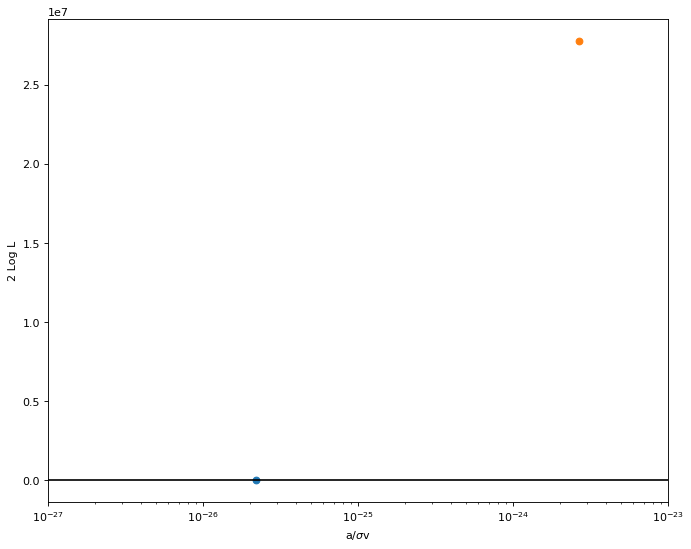

In [21]:
print(testpoints3/testpoints3*2.2e-26)
print(testpoints3)
print(testpoints3_2sig/testpoints3*2.2e-26)

plt.figure(figsize=(10, 8), dpi=80)
fntsz = 20
sizeofdot = 70


plt.ylabel('2 Log L')
plt.xlabel(r'a/$\sigma$v')
plt.hlines(0, -10, 10)
plt.xlim(1e-27, 1e-23)
plt.xscale('log')
#plt.ylim(0, 10)
plt.scatter(testpoints3/testpoints3*2.2e-26, temp_likelihood_good-temp_likelihood_good)
plt.scatter(testpoints3_2sig/testpoints3*2.2e-26, np.abs(temp_likelihood_good-temp_likelihood_2sig))


In [11]:
for idx in range(14, 15):
    !python3 ./pymultinest_chains/multinest_marginals.py ./pymultinest_chains/6templates_testingdm/chain{idx}/{idx}

model "./pymultinest_chains/6templates_testingdm/chain14/14"
  analysing data from ./pymultinest_chains/6templates_testingdm/chain14/14.txt
  marginal likelihood:
    ln Z = -43886.8 +- 0.0
  parameters:
    a0             -0.011 +- 0.012
    a1             0.0085 +- 0.0049
    a2             0.010 +- 0.019
    a3             0.1 +- 1.4
    a4             -0.0070 +- 0.0059
    a5             0.0008 +- 0.0017
creating marginal plot ...


In [13]:
e = readfile(filelist[0])[38].data
energies = np.array(list(e)).T[0]
#cross_sec normalized to 2.2e-26
points = []
errors = []
values = []
fluxes = []
deltae_cut = np.copy(deltae[3:])
cube_limits = [(-1, 2), (-1, 2), (-1, 2), (-2, 8), (-1, 2), (-1, 2)]

In [14]:
'''
Collect the data from the files created
'''

def reverse_norm(arr, norm, deltae, error = False):
    if error:
        normhere = norm.reshape(35, 1)
        deltaehere = deltae.reshape(35, 1)
        adjusted_arr = np.array(arr)*np.array(normhere)
        counts = adjusted_arr*196608 #counts
        per = counts/(exposure_time*8500*.2) #counts divided by 13 years in seconds /.85m^2/.2

        fin = per/4/np.pi/deltaehere
    else:
        adjusted_arr = np.array(arr)*np.array(norm)
        counts = adjusted_arr*196608 #counts
        per = counts/(exposure_time*8500*.2) #counts divided by 13 years in seconds /.85m^2/.2

        fin = per/4/np.pi/deltae
    return fin #counts per MeV per sec per str per cm^2

def get_errors(middle, index, filehere, val):
    sigma1_down = np.abs(middle-10**(filehere['marginals'][val]['1sigma'][0]))
    sigma1_up = np.abs(middle-10**(filehere['marginals'][val]['1sigma'][1]))
    sigma_gap = 2*np.abs(10**(filehere['marginals'][val]['1sigma'][0])-middle)
    
    
    dist = np.abs(10**(cube_limits[val][0])-middle)
    
    if sigma_gap > dist:
        return [sigma1_down, sigma1_up], True
    else:
        return [sigma1_down, sigma1_up], False
        
points0 = []
points1 = []
points2 = []
points3 = []
points4 = []
points5 = []

errors0 = []
errors1 = []
errors2 = []
errors3 = []
errors4 = []
errors5 = []

errors0_twosig = []
errors1_twosig = []
errors2_twosig = []
errors3_twosig = []
errors4_twosig = []
errors5_twosig = []

testerr3 = []

arrow = []

f = []
mypath = './pymultinest_chains/6templates_13yrs/'
for (dirpath, dirnames, filenames) in walk(mypath):
    f.append(dirnames)
chains_list = f[0]

#for i in range(3, len(energies)):
    #x = (np.loadtxt(MYDIR + '/params' + str(i) + 'stats.dat', skiprows = 4, dtype = 'float', max_rows = 5).T)

# i think i need to go in order of the energies, not just the list of filenames
for number in range(3, len(energies)):
    file = 'chain' + str(number)
    number = re.sub('\D', '', str(file))
    path_to_this_file = mypath + file + '/' + str(number) + 'stats.json'
    f = open(path_to_this_file)
    filehere = json.load(f)
    print(path_to_this_file)
    '''
    points0.append((filehere['marginals'][0]['median']))
    points1.append((filehere['marginals'][1]['median']))
    points2.append((filehere['marginals'][2]['median']))
    points3.append((filehere['marginals'][3]['median']))
    points4.append((filehere['marginals'][4]['median']))
    errors0.append((filehere['marginals'][0]['sigma']))
    errors1.append((filehere['marginals'][1]['sigma']))
    errors2.append((filehere['marginals'][2]['sigma']))
    errors3.append((filehere['marginals'][3]['sigma']))
    errors4.append((filehere['marginals'][4]['sigma']))
    '''
    
    testpoints0 = (10**(filehere['marginals'][0]['median']))
    testpoints1 = (10**(filehere['marginals'][1]['median']))
    testpoints2 = (10**(filehere['marginals'][2]['median']))
    testpoints3 = (10**(filehere['marginals'][3]['median']))
    testpoints4 = (10**(filehere['marginals'][4]['median']))
    testpoints5 = (10**(filehere['marginals'][5]['median']))

    errors_pi, errors0_twosig = get_errors(testpoints0, 0, filehere, 0)
    errors_ics, errors1_twosig = get_errors(testpoints1, 0, filehere, 1)
    errors_brem, errors2_twosig = get_errors(testpoints2, 0, filehere, 2)
    errors_dm, errors3_twosig = get_errors(testpoints3, 0, filehere, 3)
    errors_egb, errors4_twosig = get_errors(testpoints4, 0, filehere, 4)
    errors_sources, errors5_twosig = get_errors(testpoints5, 0, filehere, 4)
    

    
    arrow.append([errors0_twosig, errors1_twosig, errors2_twosig, errors3_twosig, errors4_twosig, errors5_twosig])
    
    #want line to be one order of magnitude below the top part of the line
    order = 100
    
    if errors0_twosig == True:
        points0.append(10**(filehere['marginals'][0]['2sigma'][1]))
        sig1 = 10**(filehere['marginals'][0]['2sigma'][1])
        errors0.append([np.abs(sig1/order-sig1), 0])
    else:
        points0.append(10**(filehere['marginals'][0]['median']))
        errors0.append(errors_pi)
    if errors1_twosig == True:
        points1.append(10**(filehere['marginals'][1]['2sigma'][1]))
        sig1 = 10**(filehere['marginals'][1]['2sigma'][1])
        errors1.append([np.abs(sig1/order-sig1), 0])
    else:
        points1.append(10**(filehere['marginals'][1]['median']))
        errors1.append(errors_ics)
    if errors2_twosig == True:
        points2.append(10**(filehere['marginals'][2]['2sigma'][1]))
        sig1 = 10**(filehere['marginals'][2]['2sigma'][1])
        errors2.append([np.abs(sig1/order-sig1), 0])
    else:
        points2.append(10**(filehere['marginals'][2]['median']))
        errors2.append(errors_brem)
    if errors3_twosig == True:
        points3.append(10**(filehere['marginals'][3]['2sigma'][1]))
        sig1 = 10**(filehere['marginals'][3]['2sigma'][1])
        errors3.append([np.abs(sig1/order-sig1), 0])
    else:
        points3.append(10**(filehere['marginals'][3]['median']))
        errors3.append(errors_dm)
    testerr3.append(10**(filehere['marginals'][3]['median']))
    if errors4_twosig == True:
        points4.append(10**(filehere['marginals'][4]['2sigma'][1]))
        sig1 = 10**(filehere['marginals'][4]['2sigma'][1])
        errors4.append([np.abs(sig1/order-sig1), 0])
    else:
        points4.append(10**(filehere['marginals'][4]['median']))
        errors4.append(errors_egb)
    if errors5_twosig == True:
        points5.append(10**(filehere['marginals'][5]['2sigma'][1]))
        sig1 = 10**(filehere['marginals'][5]['2sigma'][1])
        errors5.append([np.abs(sig1/order-sig1), 0])
    else:
        points5.append(10**(filehere['marginals'][5]['median']))
        errors5.append(errors_egb)
    
    #cube_limits = [(-2, 4), (-2, 4), (-3, 6), (-6, 12), (-3, 6)]
    #print(int(number))
    
    
    
piflux = reverse_norm(points0, normals[0], deltae_cut)
piflux_err = reverse_norm(errors0, normals[0], deltae_cut, error = True).T
icsflux = reverse_norm(points1, normals[1], deltae_cut)
icsflux_err = reverse_norm(errors1, normals[1], deltae_cut, error = True).T
bremflux = reverse_norm(points2, normals[2], deltae_cut)
bremflux_err = reverse_norm(errors2, normals[2], deltae_cut, error = True).T
dmflux = reverse_norm(points3, normals[3][0], deltae_cut)
dmfluxtest = reverse_norm(testerr3, normals[3][0], deltae_cut)
dmflux_err = reverse_norm(errors3, normals[3][0], deltae_cut, error = True).T
egbflux = reverse_norm(points4, normals[4], deltae_cut)
egbflux_err = reverse_norm(errors4, normals[4], deltae_cut, error = True).T
sourcesflux = reverse_norm(points5, normals[5], deltae_cut)
sourcesflux_err = reverse_norm(errors5, normals[5], deltae_cut, error = True).T
arrow = np.array(arrow).T


./pymultinest_chains/6templates/chain3/3stats.json
./pymultinest_chains/6templates/chain4/4stats.json
./pymultinest_chains/6templates/chain5/5stats.json
./pymultinest_chains/6templates/chain6/6stats.json
./pymultinest_chains/6templates/chain7/7stats.json
./pymultinest_chains/6templates/chain8/8stats.json
./pymultinest_chains/6templates/chain9/9stats.json
./pymultinest_chains/6templates/chain10/10stats.json
./pymultinest_chains/6templates/chain11/11stats.json
./pymultinest_chains/6templates/chain12/12stats.json
./pymultinest_chains/6templates/chain13/13stats.json
./pymultinest_chains/6templates/chain14/14stats.json
./pymultinest_chains/6templates/chain15/15stats.json
./pymultinest_chains/6templates/chain16/16stats.json
./pymultinest_chains/6templates/chain17/17stats.json
./pymultinest_chains/6templates/chain18/18stats.json
./pymultinest_chains/6templates/chain19/19stats.json
./pymultinest_chains/6templates/chain20/20stats.json
./pymultinest_chains/6templates/chain21/21stats.json
./pymul

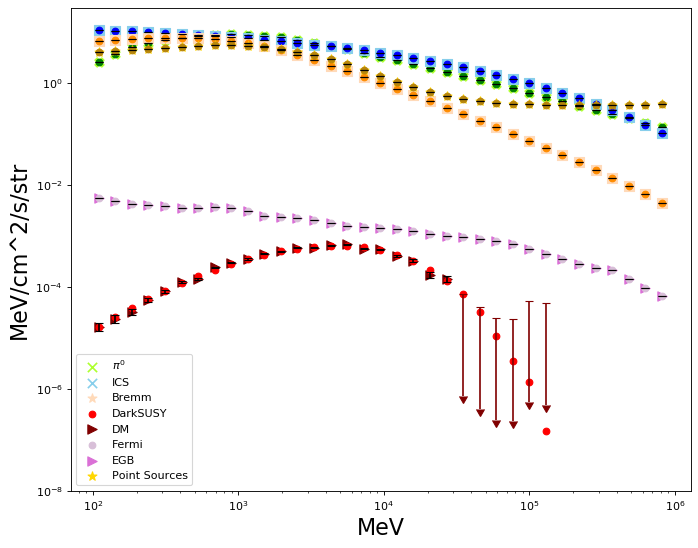

In [15]:
plt.figure(figsize=(10, 8), dpi=80)
fntsz = 20
sizeofdot = 70
norm = 1
lowlimits = np.full((len(arrow[3])), True)

units = deltae_cut*8500*exposure_time*4*np.pi/196608*.2
cut_energy = energies[3:]

#Pi0
for i in range(0, len(arrow[0])):
    if arrow[0][i] == True:
        plt.errorbar(cut_energy[i], piflux[i]*cut_energy[i]**2, yerr = np.array([(piflux_err[0][i]*cut_energy[i]**2, piflux_err[1][i]*cut_energy[i]**2)]).T, uplims = arrow[0][i], capsize = 4, color = 'black', ms = 10, ls = '')
    else:
        plt.scatter(cut_energy[i], piflux[i]*cut_energy[i]**2, color = 'greenyellow', marker = 'X', s = sizeofdot)
        plt.errorbar(cut_energy[i], piflux[i]*cut_energy[i]**2, yerr = np.array([(piflux_err[0][i]*cut_energy[i]**2, piflux_err[1][i]*cut_energy[i]**2)]).T, capsize = 4, color = 'black', ms = 10, ls = '')
plt.scatter(cut_energy, normals[0]/units*cut_energy**2, color = 'green')
plt.scatter(0, 0, label = r'$\pi^0$', color = 'greenyellow', marker = 'x', s = sizeofdot)



#ICS
for i in range(0, len(arrow[1])):
    if arrow[1][i] == True:
        plt.errorbar(cut_energy[i], icsflux[i]*cut_energy[i]**2, yerr = np.array([(icsflux_err[0][i]*cut_energy[i]**2, icsflux_err[1][i]*cut_energy[i]**2)]).T, uplims = arrow[1][i], capsize = 4, color = 'black', ms = 10, ls = '')
    else:
        plt.scatter(cut_energy[i], icsflux[i]*cut_energy[i]**2, color = 'skyblue', marker = 's', s = sizeofdot)
        plt.errorbar(cut_energy[i], icsflux[i]*cut_energy[i]**2, yerr = np.array([(icsflux_err[0][i]*cut_energy[i]**2, icsflux_err[1][i]*cut_energy[i]**2)]).T, capsize = 4, color = 'black', ms = 10, ls = '')
plt.scatter(cut_energy, normals[1]/units*cut_energy**2, color = 'blue')
plt.scatter(0, 0, label = 'ICS', color = 'skyblue', marker = 'x', s = sizeofdot)


#plt.scatter(cut_energy[27], reverse_norm(10**(0.049139889547365305), normals[1][27], deltae_cut[27])*cut_energy[27]**2, color = 'green')
#plt.scatter(cut_energy[27], reverse_norm(10**(-0.19407879963313424), normals[1][27], deltae_cut[27])*cut_energy[27]**2, color = 'green')
#plt.scatter(cut_energy[27], reverse_norm(10**(-0.054794496088809604), normals[1][27], deltae_cut[27])*cut_energy[27]**2, color = 'purple')


#Bremm
for i in range(0, len(arrow[2])):
    if arrow[2][i] == True:
        plt.errorbar(cut_energy[i], bremflux[i]*cut_energy[i]**2, yerr = np.array([(bremflux_err[0][i]*cut_energy[i]**2, bremflux_err[1][i]*cut_energy[i]**2)]).T, uplims = arrow[2][i], capsize = 4, color = 'black', ms = 10, ls = '')
    else:
        plt.scatter(cut_energy[i], bremflux[i]*cut_energy[i]**2, color = 'peachpuff', marker = 's', s = sizeofdot)
        plt.errorbar(cut_energy[i], bremflux[i]*cut_energy[i]**2, yerr = np.array([(bremflux_err[0][i]*cut_energy[i]**2, bremflux_err[1][i]*cut_energy[i]**2)]).T, capsize = 4, color = 'black', ms = 10, ls = '')
plt.scatter(cut_energy, normals[2]/units*cut_energy**2, color = 'darkorange')
plt.scatter(0, 0, label = 'Bremm', color = 'peachpuff', marker = '*', s = sizeofdot)


#Dark matter
for i in range(0, len(arrow[3])):
    if arrow[3][i] == True:
        plt.errorbar(cut_energy[i], dmflux[i]*cut_energy[i]**2, yerr = np.array([(dmflux_err[0][i]*cut_energy[i]**2, dmflux_err[1][i]*cut_energy[i]**2)]).T, uplims = arrow[3][i], capsize = 4, color = 'maroon', ms = 10, ls = '')
    else:
        plt.scatter(cut_energy[i], dmflux[i]*cut_energy[i]**2, color = 'maroon', marker = '>', s = sizeofdot)
        plt.errorbar(cut_energy[i], dmflux[i]*cut_energy[i]**2, yerr = np.array([(dmflux_err[0][i]*cut_energy[i]**2, dmflux_err[1][i]*cut_energy[i]**2)]).T, capsize = 4, color = 'black', ms = 10, ls = '')
plt.scatter(cut_energy, normals[3]/units*cut_energy**2, color = 'red', label = 'DarkSUSY')
plt.scatter(0, 0, label = 'DM', color = 'maroon', marker = '>', s = sizeofdot)


#EGB
for i in range(0, len(arrow[4])):
    if arrow[4][i] == True:
        plt.errorbar(cut_energy[i], egbflux[i]*cut_energy[i]**2, yerr = np.array([(egbflux_err[0][i]*cut_energy[i]**2, egbflux_err[1][i]*cut_energy[i]**2)]).T, uplims = arrow[4][i], capsize = 4, color = 'black', ms = 10, ls = '')
    else:
        plt.scatter(cut_energy[i], egbflux[i]*cut_energy[i]**2, color = 'orchid', marker = '>', s = sizeofdot)
        plt.errorbar(cut_energy[i], egbflux[i]*cut_energy[i]**2, yerr = np.array([(egbflux_err[0][i]*cut_energy[i]**2, egbflux_err[1][i]*cut_energy[i]**2)]).T, capsize = 4, color = 'black', ms = 10, ls = '')
plt.scatter(cut_energy, normals[4]/units*cut_energy**2, color = 'thistle', label = 'Fermi')
plt.scatter(0, 0, label = 'EGB', color = 'orchid', marker = '>', s = sizeofdot)

#Point Sources
for i in range(0, len(arrow[5])):
    if arrow[5][i] == True:
        plt.errorbar(cut_energy[i], sourcesflux[i]*cut_energy[i]**2, yerr = np.array([(sourcesflux_err[0][i]*cut_energy[i]**2, sourcesflux_err[1][i]*cut_energy[i]**2)]).T, uplims = arrow[5][i], capsize = 4, color = 'black', ms = 10, ls = '')
    else:
        plt.scatter(cut_energy[i], sourcesflux[i]*cut_energy[i]**2, color = 'gold', marker = '*', s = sizeofdot)
        plt.errorbar(cut_energy[i], sourcesflux[i]*cut_energy[i]**2, yerr = np.array([(sourcesflux_err[0][i]*cut_energy[i]**2, sourcesflux_err[1][i]*cut_energy[i]**2)]).T, capsize = 4, color = 'black', ms = 10, ls = '')
plt.scatter(cut_energy, normals[5]/units*cut_energy**2, color = 'darkgoldenrod')
plt.scatter(0, 0, label = 'Point Sources', color = 'gold', marker = '*', s = sizeofdot)

#plt.scatter(cut_energy[27], reverse_norm(10**(0.1060309379367271), normals[4][27], deltae_cut[27])*cut_energy[27]**2, color = 'green')
#plt.scatter(cut_energy[27], reverse_norm(10**(0.013060946061642112), normals[4][27], deltae_cut[27])*cut_energy[27]**2, color = 'green')
#plt.scatter(cut_energy[27], reverse_norm(10**(0.058146620211512644), normals[4][27], deltae_cut[27])*cut_energy[27]**2, color = 'purple')


plt.ylabel(r'MeV/cm^2/s/str', fontsize=fntsz)
plt.xlabel('MeV', fontsize = fntsz)
#plt.legend(fontsize = 15)
plt.yscale('log')
plt.xscale('log')
#plt.ylim(1e-10, 1e-1)
plt.ylim(1e-8, 3e1)
plt.legend()
plt.savefig('images/6templates1_13yrs.pdf')


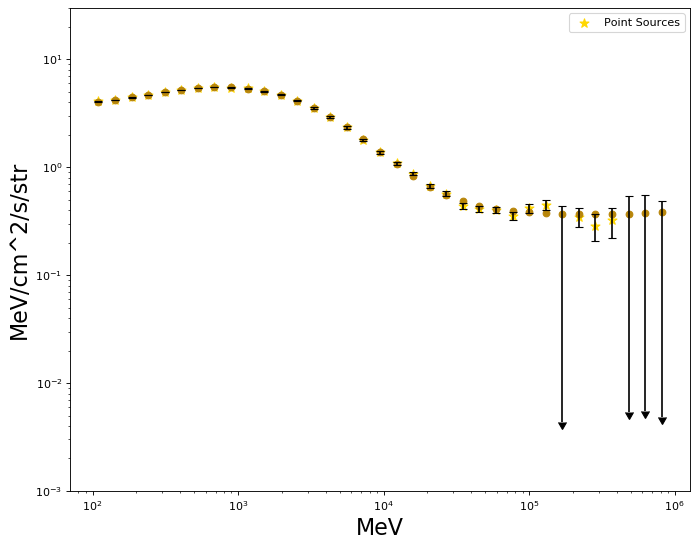

In [16]:
plt.figure(figsize=(10, 8), dpi=80)
fntsz = 20
sizeofdot = 70
norm = 1
lowlimits = np.full((len(arrow[3])), True)

units = deltae_cut*8500*exposure_time*4*np.pi/196608*.2
cut_energy = energies[3:]

#Point Sources
for i in range(0, len(arrow[5])):
    if arrow[5][i] == True:
        plt.errorbar(cut_energy[i], sourcesflux[i]*cut_energy[i]**2, yerr = np.array([(sourcesflux_err[0][i]*cut_energy[i]**2, sourcesflux_err[1][i]*cut_energy[i]**2)]).T, uplims = arrow[5][i], capsize = 4, color = 'black', ms = 10, ls = '')
    else:
        plt.scatter(cut_energy[i], sourcesflux[i]*cut_energy[i]**2, color = 'gold', marker = '*', s = sizeofdot)
        plt.errorbar(cut_energy[i], sourcesflux[i]*cut_energy[i]**2, yerr = np.array([(sourcesflux_err[0][i]*cut_energy[i]**2, sourcesflux_err[1][i]*cut_energy[i]**2)]).T, capsize = 4, color = 'black', ms = 10, ls = '')
plt.scatter(cut_energy, normals[5]/units*cut_energy**2, color = 'darkgoldenrod')
plt.scatter(0, 0, label = 'Point Sources', color = 'gold', marker = '*', s = sizeofdot)

plt.ylabel(r'MeV/cm^2/s/str', fontsize=fntsz)
plt.xlabel('MeV', fontsize = fntsz)
#plt.legend(fontsize = 15)
plt.yscale('log')
plt.xscale('log')
#plt.ylim(1e-10, 1e-1)
plt.ylim(1e-3, 3e1)
plt.legend()


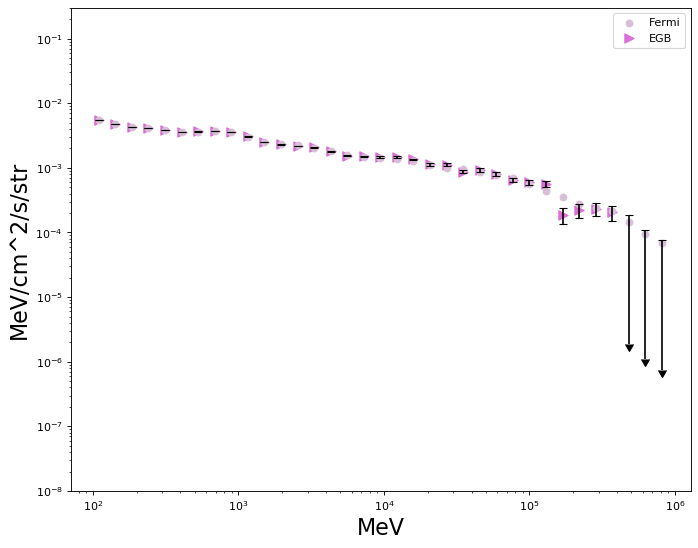

In [25]:
plt.figure(figsize=(10, 8), dpi=80)
fntsz = 20
sizeofdot = 70
norm = 1
lowlimits = np.full((len(arrow[3])), True)

units = deltae_cut*8500*exposure_time*4*np.pi/196608*.2
cut_energy = energies[3:]

#EGB
for i in range(0, len(arrow[4])):
    if arrow[4][i] == True:
        plt.errorbar(cut_energy[i], egbflux[i]*cut_energy[i]**2, yerr = np.array([(egbflux_err[0][i]*cut_energy[i]**2, egbflux_err[1][i]*cut_energy[i]**2)]).T, uplims = arrow[4][i], capsize = 4, color = 'black', ms = 10, ls = '')
    else:
        plt.scatter(cut_energy[i], egbflux[i]*cut_energy[i]**2, color = 'orchid', marker = '>', s = sizeofdot)
        plt.errorbar(cut_energy[i], egbflux[i]*cut_energy[i]**2, yerr = np.array([(egbflux_err[0][i]*cut_energy[i]**2, egbflux_err[1][i]*cut_energy[i]**2)]).T, capsize = 4, color = 'black', ms = 10, ls = '')
plt.scatter(cut_energy, normals[4]/units*cut_energy**2, color = 'thistle', label = 'Fermi')
plt.scatter(0, 0, label = 'EGB', color = 'orchid', marker = '>', s = sizeofdot)

plt.ylabel(r'MeV/cm^2/s/str', fontsize=fntsz)
plt.xlabel('MeV', fontsize = fntsz)
#plt.legend(fontsize = 15)
plt.yscale('log')
plt.xscale('log')
#plt.ylim(1e-10, 1e-1)
plt.ylim(1e-8, 3e-1)
plt.legend()


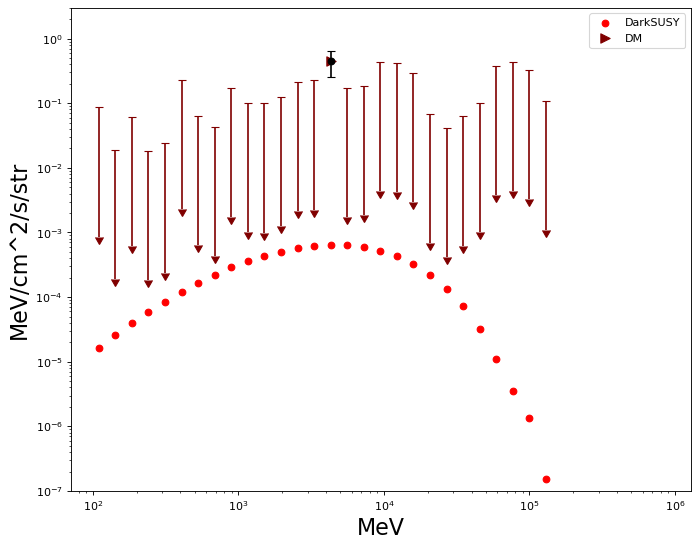

In [29]:
plt.figure(figsize=(10, 8), dpi=80)
fntsz = 20
sizeofdot = 70
norm = 1
lowlimits = np.full((len(arrow[3])), True)

units = deltae_cut*8500*exposure_time*4*np.pi/196608*.2
cut_energy = energies[3:]

#Dark matter
for i in range(0, len(arrow[3])):
    if arrow[3][i] == True:
        plt.errorbar(cut_energy[i], dmflux[i]*cut_energy[i]**2, yerr = np.array([(dmflux_err[0][i]*cut_energy[i]**2, dmflux_err[1][i]*cut_energy[i]**2)]).T, uplims = arrow[3][i], capsize = 4, color = 'maroon', ms = 10, ls = '')
    else:
        plt.scatter(cut_energy[i], dmflux[i]*cut_energy[i]**2, color = 'maroon', marker = '>', s = sizeofdot)
        plt.errorbar(cut_energy[i], dmflux[i]*cut_energy[i]**2, yerr = np.array([(dmflux_err[0][i]*cut_energy[i]**2, dmflux_err[1][i]*cut_energy[i]**2)]).T, capsize = 4, color = 'black', ms = 10, ls = '')
plt.scatter(cut_energy, normals[3]/units*cut_energy**2, color = 'red', label = 'DarkSUSY')
plt.scatter(0, 0, label = 'DM', color = 'maroon', marker = '>', s = sizeofdot)
plt.scatter(cut_energy[14], dmflux[14]*cut_energy[14]**2, c = 'black')

plt.ylabel(r'MeV/cm^2/s/str', fontsize=fntsz)
plt.xlabel('MeV', fontsize = fntsz)
#plt.legend(fontsize = 15)
plt.yscale('log')
plt.xscale('log')
#plt.ylim(1e-10, 1e-1)
plt.ylim(1e-7, 3e0)
plt.legend()


In [30]:
points = readfile(point_sources[0])

In [46]:
print(points[-1].header)

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               SUMMARY = 'ImageHDUs of 608 Fermi 4FGL (2nd Data Release, 10-year)-identified &'CONTINUE  'point sources in the central 23 degrees (b & l) of the Milky Way, &' CONTINUE  'reproduced according to their best-fit spectra by the 4FGL &'        CONTINUE  'Catalog, spanning 35 evenly log-spaced energy bins, with the &'      CONTINUE  'central (log-spaced) energy as the signature energy specified in &'  CONTINUE  'each ImageHDU''s header.'                                            CAVEAT  = 'The ImageHDUs are not convoluted by point-spread-functions (PSFs). &'CONTINUE  'They only contain single-pixe